# Pre-Flipped Classroom Grade Analysis
## Analyzing Final Grades by Academic Year (2018-2020)

### 📚 Analysis Overview:
This notebook analyzes student performance **before** the implementation of the Flipped Classroom methodology.
We examine final grades (OCJENA na kontinuiranom) across different academic years to establish baseline performance.

### 🎯 Key Questions:
1. **How did final grades distribute across academic years?**
2. **Were there significant year-to-year differences in performance?**
3. **What was the baseline pass rate before FC implementation?**
4. **How consistent were grade distributions?**

### 📊 Dataset:
- **Source**: `data/before_fc.csv`
- **Period**: Pre-Flipped Classroom implementation
- **Key Variables**: Academic Year (ak godina), Final Grade (OCJENA na kontinuiranom)
- **Assessment Components**: Kolokvij II, Virtualna firma, Završni ispit

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical libraries
import scipy.stats as stats
from scipy.stats import (
    chi2_contingency, f_oneway, kruskal, mannwhitneyu,
    shapiro, normaltest, pearsonr, spearmanr
)

# Data cleaning and preprocessing
import re
from pathlib import Path
import warnings

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['figure.titlesize'] = 16

print("✅ Libraries loaded successfully!")
print("📊 Analysis environment configured for pre-FC grade analysis")

✅ Libraries loaded successfully!
📊 Analysis environment configured for pre-FC grade analysis


## 1. Data Loading and Initial Exploration

In [2]:
# Load the before_fc.csv data
data_path = Path('../data/before_fc.csv')

if not data_path.exists():
    print(f"❌ Data file not found at {data_path}")
    print("Please ensure the before_fc.csv file exists in the data directory.")
else:
    # Load data with proper encoding
    try:
        df_raw = pd.read_csv(data_path, encoding='utf-8')
    except UnicodeDecodeError:
        try:
            df_raw = pd.read_csv(data_path, encoding='latin-1')
        except UnicodeDecodeError:
            df_raw = pd.read_csv(data_path, encoding='cp1252')
    
    print(f"✅ Data loaded successfully!")
    print(f"Shape: {df_raw.shape}")
    print(f"Columns: {list(df_raw.columns)}")
    
    # Display first few rows
    print(f"\n📊 First 5 rows:")
    display(df_raw.head())
    
    # Display data types
    print(f"\n📋 Data types:")
    print(df_raw.dtypes)
    
    # Check for missing values
    print(f"\n❓ Missing values:")
    missing_summary = df_raw.isnull().sum()
    for col, missing_count in missing_summary.items():
        if missing_count > 0:
            print(f"  {col}: {missing_count} ({missing_count/len(df_raw)*100:.1f}%)")
        else:
            print(f"  {col}: 0 (0.0%)")

✅ Data loaded successfully!
Shape: (160, 11)
Columns: ['rbr', 'ak godina', 'Matični broj', 'Ime', 'Prezime', 'status', 'Kolokvij II 35b prag 17', 'Virtualna firma  20b prag 9', 'Završni ispit 30b prag 15', 'Ukupno', 'OCJENA na kontinuiranom']

📊 First 5 rows:


,rbr,ak godina,Matični broj,Ime,Prezime,status,Kolokvij II 35b prag 17,Virtualna firma 20b prag 9,Završni ispit 30b prag 15,Ukupno,OCJENA na kontinuiranom
0,1,2018/19,0016127779,Petra,Antolić,redovni,0,NaN,NaN,NaN,1
1,2,2018/19,0016127721,Iva,Bogović,redovni,5,NaN,NaN,NaN,1
2,3,2018/19,0016128003,Martina,Buček,redovni,"9,0",NaN,NaN,NaN,1
3,4,2018/19,0016127347,Barbara,Črešnjek,redovni,14,NaN,NaN,NaN,1
4,5,2018/19,0016128092,Ines,Diaković,redovni,9,NaN,NaN,NaN,1



📋 Data types:
rbr                             int64
ak godina                      object
Matični broj                   object
Ime                            object
Prezime                        object
status                         object
Kolokvij II 35b prag 17        object
Virtualna firma  20b prag 9    object
Završni ispit 30b prag 15      object
Ukupno                         object
OCJENA na kontinuiranom         int64
dtype: object

❓ Missing values:
  rbr: 0 (0.0%)
  ak godina: 0 (0.0%)
  Matični broj: 5 (3.1%)
  Ime: 0 (0.0%)
  Prezime: 0 (0.0%)
  status: 62 (38.8%)
  Kolokvij II 35b prag 17: 12 (7.5%)
  Virtualna firma  20b prag 9: 121 (75.6%)
  Završni ispit 30b prag 15: 123 (76.9%)
  Ukupno: 75 (46.9%)
  OCJENA na kontinuiranom: 0 (0.0%)


## 2. Data Cleaning and Preprocessing

In [3]:
def clean_before_fc_data(data):
    """
    Clean and preprocess the before_fc.csv data
    """
    print("🧹 CLEANING BEFORE-FC DATA")
    print("="*50)
    
    # Create a copy for cleaning
    df = data.copy()
    
    # Clean column names (remove leading/trailing spaces)
    df.columns = df.columns.str.strip()
    print(f"📋 Cleaned column names: {list(df.columns)}")
    
    # Clean academic year column
    if 'ak godina' in df.columns:
        # Extract year and clean format - take only first part before /
        df['academic_year_full'] = df['ak godina'].astype(str).str.strip()
        # Extract just the year (e.g., 2018 from 2018/19)
        df['academic_year'] = df['academic_year_full'].str.split('/').str[0].astype(int)
        print(f"📅 Academic years found (full): {sorted(df['academic_year_full'].unique())}")
        print(f"📅 Academic years extracted: {sorted(df['academic_year'].unique())}")
    
    # Clean final grade column
    if 'OCJENA na kontinuiranom' in df.columns:
        df['final_grade'] = pd.to_numeric(df['OCJENA na kontinuiranom'], errors='coerce')
        print(f"📊 Final grades range: {df['final_grade'].min():.0f} - {df['final_grade'].max():.0f}")
        print(f"📊 Grade distribution: {df['final_grade'].value_counts().sort_index()}")
    
    # Clean numeric columns (handle European decimal format with commas)
    numeric_columns = ['Kolokvij II 35b prag 17', 'Virtualna firma  20b prag 9', 'Završni ispit 30b prag 15', 'Ukupno']
    
    for col in numeric_columns:
        if col in df.columns:
            # Replace commas with dots and convert to numeric
            df[col + '_clean'] = df[col].astype(str).str.replace(',', '.', regex=False)
            df[col + '_clean'] = pd.to_numeric(df[col + '_clean'], errors='coerce')
            
            # Create short column names
            if 'Kolokvij' in col:
                df['kolokvij_score'] = df[col + '_clean']
            elif 'Virtualna' in col:
                df['virtualna_firma_score'] = df[col + '_clean']
            elif 'Završni' in col:
                df['final_exam_score'] = df[col + '_clean']
            elif 'Ukupno' in col:
                df['total_score'] = df[col + '_clean']
    
    # Clean student information
    if 'Ime' in df.columns and 'Prezime' in df.columns:
        df['first_name'] = df['Ime'].astype(str).str.strip()
        df['last_name'] = df['Prezime'].astype(str).str.strip()
        df['full_name'] = df['first_name'] + ' ' + df['last_name']
    
    # Clean student status
    if 'status' in df.columns:
        df['student_status'] = df['status'].astype(str).str.strip().str.lower()
        print(f"👥 Student status distribution: {df['student_status'].value_counts()}")
    
    # Create pass/fail indicator
    if 'final_grade' in df.columns:
        df['passed'] = (df['final_grade'] >= 2).astype(int)
        pass_rate = df['passed'].mean() * 100
        print(f"✅ Overall pass rate: {pass_rate:.1f}%")
        print(f"✅ Passed students: {df['passed'].sum()}, Failed students: {(df['passed'] == 0).sum()}")
    
    # Create grade categories
    if 'final_grade' in df.columns:
        def categorize_grade(grade):
            if pd.isna(grade):
                return 'Missing'
            elif grade == 1:
                return 'Fail (1)'
            elif grade == 2:
                return 'Pass (2)'
            elif grade == 3:
                return 'Good (3)'
            elif grade == 4:
                return 'Very Good (4)'
            elif grade == 5:
                return 'Excellent (5)'
            else:
                return 'Other'
        
        df['grade_category'] = df['final_grade'].apply(categorize_grade)
        print(f"📊 Grade categories: {df['grade_category'].value_counts()}")
    
    # Remove rows with missing essential data
    essential_columns = ['academic_year', 'final_grade']
    before_cleaning = len(df)
    df_clean = df.dropna(subset=essential_columns)
    after_cleaning = len(df_clean)
    
    print(f"\n🧹 CLEANING SUMMARY:")
    print(f"Rows before cleaning: {before_cleaning}")
    print(f"Rows after cleaning: {after_cleaning}")
    print(f"Rows removed: {before_cleaning - after_cleaning} ({(before_cleaning - after_cleaning)/before_cleaning*100:.1f}%)")
    
    return df_clean

# Clean the data
df = clean_before_fc_data(df_raw)

🧹 CLEANING BEFORE-FC DATA
📋 Cleaned column names: ['rbr', 'ak godina', 'Matični broj', 'Ime', 'Prezime', 'status', 'Kolokvij II 35b prag 17', 'Virtualna firma  20b prag 9', 'Završni ispit 30b prag 15', 'Ukupno', 'OCJENA na kontinuiranom']
📅 Academic years found (full): ['2018/19', '2019/20', '2020/21']
📅 Academic years extracted: [np.int64(2018), np.int64(2019), np.int64(2020)]
📊 Final grades range: 1 - 5
📊 Grade distribution: final_grade
1    126
2      7
3      8
4      9
5     10
Name: count, dtype: int64
👥 Student status distribution: student_status
redovni       90
nan           62
izvanredni     5
izv            3
Name: count, dtype: int64
✅ Overall pass rate: 21.2%
✅ Passed students: 34, Failed students: 126
📊 Grade categories: grade_category
Fail (1)         126
Excellent (5)     10
Very Good (4)      9
Good (3)           8
Pass (2)           7
Name: count, dtype: int64

🧹 CLEANING SUMMARY:
Rows before cleaning: 160
Rows after cleaning: 160
Rows removed: 0 (0.0%)


## 3. Exploratory Data Analysis by Academic Year

In [4]:
# Basic statistics by academic year
print("📊 ACADEMIC YEAR OVERVIEW")
print("="*50)

# Sample size by year
year_counts = df['academic_year'].value_counts().sort_index()
print(f"\n👥 Students per academic year:")
for year, count in year_counts.items():
    percentage = count / len(df) * 100
    print(f"  {year}: {count} students ({percentage:.1f}%)")

# Grade statistics by year
print(f"\n📈 GRADE STATISTICS BY YEAR:")
print("="*60)

grade_stats = df.groupby('academic_year')['final_grade'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(3)

print(grade_stats)

# Pass rates by year
print(f"\n✅ PASS RATES BY YEAR:")
print("="*40)

pass_rates = df.groupby('academic_year')['passed'].agg(['count', 'sum', 'mean']).round(3)
pass_rates.columns = ['Total_Students', 'Passed_Students', 'Pass_Rate']
pass_rates['Pass_Rate_Percent'] = pass_rates['Pass_Rate'] * 100

for year in pass_rates.index:
    total = pass_rates.loc[year, 'Total_Students']
    passed = pass_rates.loc[year, 'Passed_Students']
    rate = pass_rates.loc[year, 'Pass_Rate_Percent']
    print(f"  {year}: {passed:.0f}/{total:.0f} students ({rate:.1f}%)")

# Grade distribution by year
print(f"\n📊 DETAILED GRADE DISTRIBUTION BY YEAR:")
print("="*50)

grade_distribution = pd.crosstab(df['academic_year'], df['final_grade'], margins=True)
print(grade_distribution)

# Percentage distribution
print(f"\n📊 GRADE DISTRIBUTION BY YEAR (PERCENTAGES):")
print("="*55)

grade_pct_distribution = pd.crosstab(df['academic_year'], df['final_grade'], normalize='index') * 100
print(grade_pct_distribution.round(1))

📊 ACADEMIC YEAR OVERVIEW

👥 Students per academic year:
  2018: 46 students (28.7%)
  2019: 62 students (38.8%)
  2020: 52 students (32.5%)

📈 GRADE STATISTICS BY YEAR:
               count   mean  median    std  min  max
academic_year                                       
2018              46  1.848     1.0  1.382    1    5
2019              62  1.339     1.0  1.023    1    5
2020              52  1.577     1.0  1.194    1    5

✅ PASS RATES BY YEAR:
  2018: 16/46 students (34.8%)
  2019: 7/62 students (11.3%)
  2020: 11/52 students (21.2%)

📊 DETAILED GRADE DISTRIBUTION BY YEAR:
final_grade      1  2  3  4   5  All
academic_year                       
2018            30  6  1  5   4   46
2019            55  1  1  2   3   62
2020            41  0  6  2   3   52
All            126  7  8  9  10  160

📊 GRADE DISTRIBUTION BY YEAR (PERCENTAGES):
final_grade       1     2     3     4    5
academic_year                             
2018           65.2  13.0   2.2  10.9  8.7
2019           

## 4. Visual Analysis - Grade Distributions by Year

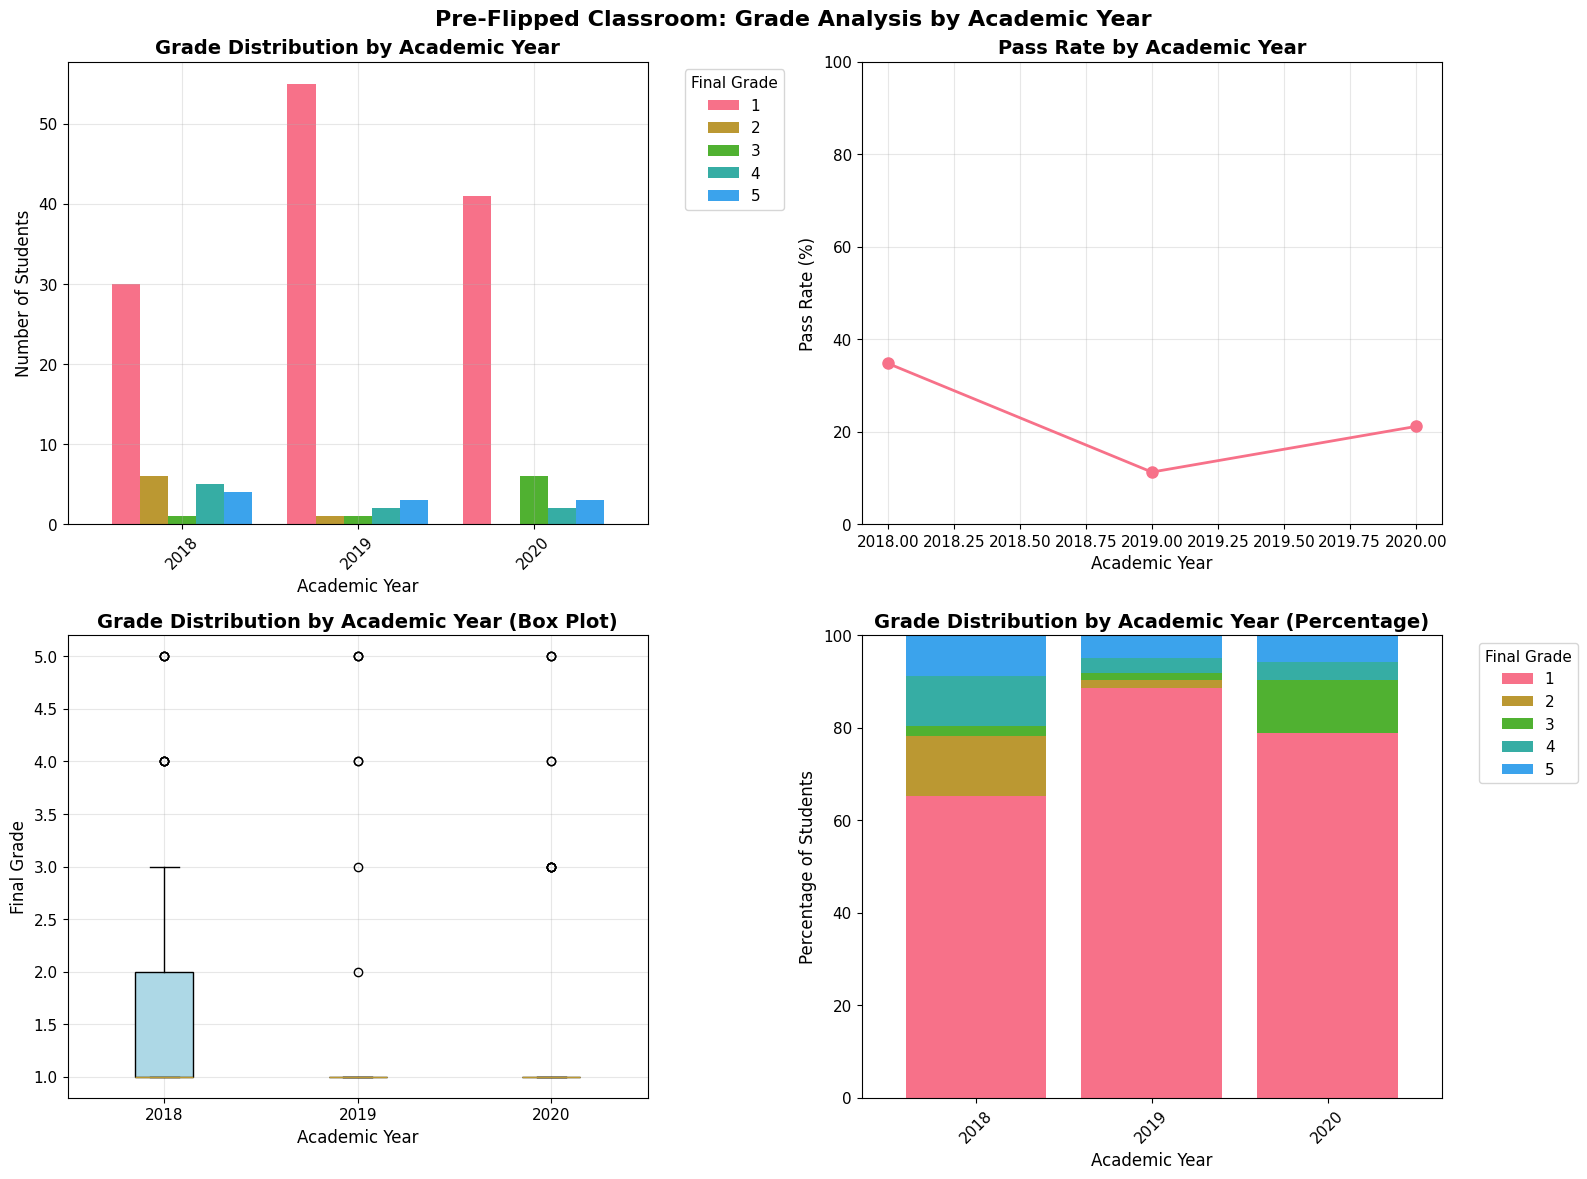


📋 SUMMARY STATISTICS TABLE:
               final_grade_count  final_grade_mean  final_grade_median  \
academic_year                                                            
2018                          46             1.848                 1.0   
2019                          62             1.339                 1.0   
2020                          52             1.577                 1.0   

               final_grade_std  passed_sum  passed_mean  Pass_Rate_Pct  
academic_year                                                           
2018                     1.382          16        0.348           34.8  
2019                     1.023           7        0.113           11.3  
2020                     1.194          11        0.212           21.2  


In [5]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Grade distribution by year - Bar chart
ax1 = axes[0, 0]
grade_dist_plot = df.groupby(['academic_year', 'final_grade']).size().unstack(fill_value=0)
grade_dist_plot.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Grade Distribution by Academic Year', fontweight='bold')
ax1.set_xlabel('Academic Year')
ax1.set_ylabel('Number of Students')
ax1.legend(title='Final Grade', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# 2. Pass rate by year - Line chart
ax2 = axes[0, 1]
pass_rate_by_year = df.groupby('academic_year')['passed'].mean() * 100
ax2.plot(pass_rate_by_year.index, pass_rate_by_year.values, 'o-', linewidth=2, markersize=8)
ax2.set_title('Pass Rate by Academic Year', fontweight='bold')
ax2.set_xlabel('Academic Year')
ax2.set_ylabel('Pass Rate (%)')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

# Add value labels on the line chart
for i, (year, rate) in enumerate(pass_rate_by_year.items()):
    ax2.annotate(f'{rate:.1f}%', (i, rate), textcoords="offset points", xytext=(0,10), ha='center')

# 3. Box plot of grades by year
ax3 = axes[1, 0]
years = sorted(df['academic_year'].unique())
grade_data_by_year = [df[df['academic_year'] == year]['final_grade'].values for year in years]
box_plot = ax3.boxplot(grade_data_by_year, labels=years, patch_artist=True)

# Color the boxes
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

ax3.set_title('Grade Distribution by Academic Year (Box Plot)', fontweight='bold')
ax3.set_xlabel('Academic Year')
ax3.set_ylabel('Final Grade')
ax3.grid(True, alpha=0.3)

# 4. Grade percentage distribution (stacked bar)
ax4 = axes[1, 1]
grade_pct_for_plot = pd.crosstab(df['academic_year'], df['final_grade'], normalize='index') * 100
grade_pct_for_plot.plot(kind='bar', stacked=True, ax=ax4, width=0.8)
ax4.set_title('Grade Distribution by Academic Year (Percentage)', fontweight='bold')
ax4.set_xlabel('Academic Year')
ax4.set_ylabel('Percentage of Students')
ax4.legend(title='Final Grade', bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.tick_params(axis='x', rotation=45)
ax4.set_ylim(0, 100)

plt.suptitle('Pre-Flipped Classroom: Grade Analysis by Academic Year', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary statistics table
print("\n📋 SUMMARY STATISTICS TABLE:")
print("="*60)

summary_stats = df.groupby('academic_year').agg({
    'final_grade': ['count', 'mean', 'median', 'std'],
    'passed': ['sum', 'mean']
}).round(3)

# Flatten column names
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns]
summary_stats['Pass_Rate_Pct'] = summary_stats['passed_mean'] * 100

print(summary_stats)

## 5. Statistical Analysis - Year-to-Year Differences

In [6]:
def statistical_analysis_by_year(data):
    """
    Perform comprehensive statistical analysis comparing grades across years
    """
    print("📊 STATISTICAL ANALYSIS: YEAR-TO-YEAR COMPARISONS")
    print("="*70)
    
    # 1. Normality tests for grades by year
    print("\n🔍 NORMALITY TESTS BY YEAR:")
    print("="*40)
    
    years = sorted(data['academic_year'].unique())
    normality_results = {}
    
    for year in years:
        year_grades = data[data['academic_year'] == year]['final_grade'].dropna()
        
        if len(year_grades) >= 3:
            # Shapiro-Wilk test
            try:
                shapiro_stat, shapiro_p = shapiro(year_grades)
                normality_results[year] = {
                    'n': len(year_grades),
                    'shapiro_p': shapiro_p,
                    'is_normal': shapiro_p > 0.05
                }
                
                normal_status = "Normal" if shapiro_p > 0.05 else "Non-normal"
                print(f"  {year}: n={len(year_grades)}, Shapiro-Wilk p={shapiro_p:.4f} ({normal_status})")
                
            except:
                print(f"  {year}: n={len(year_grades)}, Could not perform normality test")
        else:
            print(f"  {year}: n={len(year_grades)}, Insufficient data for testing")
    
    # 2. Overall comparison test (ANOVA vs Kruskal-Wallis)
    print("\n🔬 OVERALL COMPARISON TEST:")
    print("="*35)
    
    # Prepare data for testing
    grade_groups = [data[data['academic_year'] == year]['final_grade'].dropna().values 
                   for year in years if len(data[data['academic_year'] == year]['final_grade'].dropna()) > 0]
    
    if len(grade_groups) >= 2:
        # ANOVA (parametric)
        try:
            f_stat, anova_p = f_oneway(*grade_groups)
            print(f"One-way ANOVA: F={f_stat:.4f}, p={anova_p:.4f}")
            
            if anova_p < 0.05:
                print("  ✅ Significant differences between years (ANOVA)")
            else:
                print("  ❌ No significant differences between years (ANOVA)")
        except:
            print("  ⚠️ Could not perform ANOVA")
        
        # Kruskal-Wallis (non-parametric)
        try:
            kw_stat, kw_p = kruskal(*grade_groups)
            print(f"Kruskal-Wallis: H={kw_stat:.4f}, p={kw_p:.4f}")
            
            if kw_p < 0.05:
                print("  ✅ Significant differences between years (Kruskal-Wallis)")
            else:
                print("  ❌ No significant differences between years (Kruskal-Wallis)")
        except:
            print("  ⚠️ Could not perform Kruskal-Wallis test")
    
    # 3. Pairwise comparisons
    print("\n🔄 PAIRWISE COMPARISONS:")
    print("="*30)
    
    from itertools import combinations
    
    for year1, year2 in combinations(years, 2):
        grades1 = data[data['academic_year'] == year1]['final_grade'].dropna()
        grades2 = data[data['academic_year'] == year2]['final_grade'].dropna()
        
        if len(grades1) >= 3 and len(grades2) >= 3:
            # Mann-Whitney U test (non-parametric)
            try:
                u_stat, u_p = mannwhitneyu(grades1, grades2, alternative='two-sided')
                
                mean1 = grades1.mean()
                mean2 = grades2.mean()
                diff = mean2 - mean1
                
                significance = "***" if u_p < 0.001 else "**" if u_p < 0.01 else "*" if u_p < 0.05 else "ns"
                
                print(f"  {year1} vs {year2}:")
                print(f"    Mean grades: {mean1:.3f} vs {mean2:.3f} (diff: {diff:+.3f})")
                print(f"    Mann-Whitney U: p={u_p:.4f} {significance}")
                
            except Exception as e:
                print(f"  {year1} vs {year2}: Could not perform comparison - {e}")
    
    # 4. Pass rate comparisons
    print("\n✅ PASS RATE COMPARISONS:")
    print("="*30)
    
    # Chi-square test for pass rates
    pass_fail_crosstab = pd.crosstab(data['academic_year'], data['passed'])
    
    if pass_fail_crosstab.shape[0] > 1 and pass_fail_crosstab.shape[1] > 1:
        try:
            chi2, chi2_p, dof, expected = chi2_contingency(pass_fail_crosstab)
            print(f"Chi-square test for pass rates: χ²={chi2:.4f}, p={chi2_p:.4f}")
            
            if chi2_p < 0.05:
                print("  ✅ Significant differences in pass rates between years")
            else:
                print("  ❌ No significant differences in pass rates between years")
                
            # Show the crosstab
            print(f"\n📊 Pass/Fail Crosstab:")
            print(pass_fail_crosstab)
            
        except Exception as e:
            print(f"  ⚠️ Could not perform chi-square test: {e}")
    
    # 5. Effect sizes (Cohen's d for pairwise comparisons)
    print("\n📏 EFFECT SIZES (Cohen's d):")
    print("="*35)
    
    def cohens_d(group1, group2):
        """Calculate Cohen's d effect size"""
        n1, n2 = len(group1), len(group2)
        var1, var2 = group1.var(ddof=1), group2.var(ddof=1)
        
        # Pooled standard deviation
        pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        
        # Cohen's d
        d = (group1.mean() - group2.mean()) / pooled_std
        return d
    
    for year1, year2 in combinations(years, 2):
        grades1 = data[data['academic_year'] == year1]['final_grade'].dropna()
        grades2 = data[data['academic_year'] == year2]['final_grade'].dropna()
        
        if len(grades1) >= 3 and len(grades2) >= 3:
            try:
                d = cohens_d(grades1, grades2)
                
                # Interpret effect size
                if abs(d) < 0.2:
                    interpretation = "Negligible"
                elif abs(d) < 0.5:
                    interpretation = "Small"
                elif abs(d) < 0.8:
                    interpretation = "Medium"
                else:
                    interpretation = "Large"
                
                print(f"  {year1} vs {year2}: d={d:+.3f} ({interpretation})")
                
            except Exception as e:
                print(f"  {year1} vs {year2}: Could not calculate effect size - {e}")

# Run statistical analysis
statistical_analysis_by_year(df)

📊 STATISTICAL ANALYSIS: YEAR-TO-YEAR COMPARISONS

🔍 NORMALITY TESTS BY YEAR:
  2018: n=46, Shapiro-Wilk p=0.0000 (Non-normal)
  2019: n=62, Shapiro-Wilk p=0.0000 (Non-normal)
  2020: n=52, Shapiro-Wilk p=0.0000 (Non-normal)

🔬 OVERALL COMPARISON TEST:
One-way ANOVA: F=2.4204, p=0.0922
  ❌ No significant differences between years (ANOVA)
Kruskal-Wallis: H=7.6882, p=0.0214
  ✅ Significant differences between years (Kruskal-Wallis)

🔄 PAIRWISE COMPARISONS:
  2018 vs 2019:
    Mean grades: 1.848 vs 1.339 (diff: -0.509)
    Mann-Whitney U: p=0.0054 **
  2018 vs 2020:
    Mean grades: 1.848 vs 1.577 (diff: -0.271)
    Mann-Whitney U: p=0.1731 ns
  2019 vs 2020:
    Mean grades: 1.339 vs 1.577 (diff: +0.238)
    Mann-Whitney U: p=0.1743 ns

✅ PASS RATE COMPARISONS:
Chi-square test for pass rates: χ²=8.7094, p=0.0128
  ✅ Significant differences in pass rates between years

📊 Pass/Fail Crosstab:
passed          0   1
academic_year        
2018           30  16
2019           55   7
2020        

## 6. Comprehensive Summary and Insights

In [7]:
def generate_comprehensive_summary(data):
    """
    Generate a comprehensive summary of the pre-FC grade analysis
    """
    print("📋 COMPREHENSIVE ANALYSIS SUMMARY")
    print("="*50)
    
    # Overall statistics
    total_students = len(data)
    years = sorted(data['academic_year'].unique())
    overall_pass_rate = data['passed'].mean() * 100
    overall_mean_grade = data['final_grade'].mean()
    
    print(f"\n🎯 DATASET OVERVIEW:")
    print(f"{'='*25}")
    print(f"Total students: {total_students}")
    print(f"Academic years: {', '.join(str(year) for year in years)}")  # Fixed: Convert years to strings
    print(f"Overall pass rate: {overall_pass_rate:.1f}%")
    print(f"Overall mean grade: {overall_mean_grade:.2f}")
    
    # Year-specific insights
    print(f"\n📊 YEAR-SPECIFIC INSIGHTS:")
    print(f"{'='*30}")
    
    year_stats = data.groupby('academic_year').agg({
        'final_grade': ['count', 'mean', 'std'],
        'passed': 'mean'
    }).round(3)
    
    year_stats.columns = ['n_students', 'mean_grade', 'std_grade', 'pass_rate']
    year_stats['pass_rate_pct'] = year_stats['pass_rate'] * 100
    
    for year in years:
        stats = year_stats.loc[year]
        print(f"\n{year}:")
        print(f"  • Students: {stats['n_students']:.0f}")
        print(f"  • Mean grade: {stats['mean_grade']:.2f} ± {stats['std_grade']:.2f}")
        print(f"  • Pass rate: {stats['pass_rate_pct']:.1f}%")
    
    # Identify best and worst performing years
    best_year_grade = year_stats['mean_grade'].idxmax()
    worst_year_grade = year_stats['mean_grade'].idxmin()
    best_year_pass = year_stats['pass_rate_pct'].idxmax()
    worst_year_pass = year_stats['pass_rate_pct'].idxmin()
    
    print(f"\n🏆 PERFORMANCE RANKINGS:")
    print(f"{'='*28}")
    print(f"Highest mean grade: {best_year_grade} ({year_stats.loc[best_year_grade, 'mean_grade']:.2f})")
    print(f"Lowest mean grade: {worst_year_grade} ({year_stats.loc[worst_year_grade, 'mean_grade']:.2f})")
    print(f"Highest pass rate: {best_year_pass} ({year_stats.loc[best_year_pass, 'pass_rate_pct']:.1f}%)")
    print(f"Lowest pass rate: {worst_year_pass} ({year_stats.loc[worst_year_pass, 'pass_rate_pct']:.1f}%)")
    
    # Grade distribution analysis
    print(f"\n📈 GRADE DISTRIBUTION PATTERNS:")
    print(f"{'='*35}")
    
    grade_dist = data['final_grade'].value_counts().sort_index()
    total = len(data)
    
    for grade in sorted(data['final_grade'].unique()):
        count = grade_dist[grade]
        percentage = count / total * 100
        
        if grade == 1:
            grade_name = "Fail"
        elif grade == 2:
            grade_name = "Pass"
        elif grade == 3:
            grade_name = "Good"
        elif grade == 4:
            grade_name = "Very Good"
        elif grade == 5:
            grade_name = "Excellent"
        else:
            grade_name = f"Grade {grade}"
        
        print(f"  Grade {grade:.0f} ({grade_name}): {count} students ({percentage:.1f}%)")
    
    # Consistency analysis
    print(f"\n📊 CONSISTENCY ANALYSIS:")
    print(f"{'='*25}")
    
    # Coefficient of variation for grades by year
    cv_by_year = (year_stats['std_grade'] / year_stats['mean_grade']) * 100
    most_consistent = cv_by_year.idxmin()
    least_consistent = cv_by_year.idxmax()
    
    print(f"Coefficient of Variation (CV) by year:")
    for year in years:
        cv = cv_by_year[year]
        print(f"  {year}: {cv:.1f}%")
    
    print(f"\nMost consistent year: {most_consistent} (CV: {cv_by_year[most_consistent]:.1f}%)")
    print(f"Least consistent year: {least_consistent} (CV: {cv_by_year[least_consistent]:.1f}%)")
    
    # Key insights
    print(f"\n💡 KEY INSIGHTS:")
    print(f"{'='*18}")
    
    # Calculate year-to-year changes
    if len(years) > 1:
        grade_changes = []
        pass_rate_changes = []
        
        for i in range(1, len(years)):
            prev_year = years[i-1]
            curr_year = years[i]
            
            grade_change = year_stats.loc[curr_year, 'mean_grade'] - year_stats.loc[prev_year, 'mean_grade']
            pass_rate_change = year_stats.loc[curr_year, 'pass_rate_pct'] - year_stats.loc[prev_year, 'pass_rate_pct']
            
            grade_changes.append(grade_change)
            pass_rate_changes.append(pass_rate_change)
            
            print(f"\n{prev_year} → {curr_year}:")
            print(f"  • Grade change: {grade_change:+.3f}")
            print(f"  • Pass rate change: {pass_rate_change:+.1f} percentage points")
        
        # Overall trends
        overall_grade_trend = sum(grade_changes)
        overall_pass_rate_trend = sum(pass_rate_changes)
        
        print(f"\n📈 OVERALL TRENDS ({years[0]} to {years[-1]}):")
        print(f"  • Total grade change: {overall_grade_trend:+.3f}")
        print(f"  • Total pass rate change: {overall_pass_rate_trend:+.1f} percentage points")
        
        if overall_grade_trend > 0.1:
            print(f"  ✅ Grades showed improvement over time")
        elif overall_grade_trend < -0.1:
            print(f"  ⬇️ Grades showed decline over time")
        else:
            print(f"  ➡️ Grades remained relatively stable")
        
        if overall_pass_rate_trend > 5:
            print(f"  ✅ Pass rates improved over time")
        elif overall_pass_rate_trend < -5:
            print(f"  ⬇️ Pass rates declined over time")
        else:
            print(f"  ➡️ Pass rates remained relatively stable")
    
    print(f"\n🎯 BASELINE PERFORMANCE (Pre-Flipped Classroom):")
    print(f"{'='*50}")
    print(f"This analysis establishes baseline performance metrics that can be")
    print(f"compared with post-Flipped Classroom implementation results.")
    print(f"\nKey baseline metrics:")
    print(f"  • Average grade: {overall_mean_grade:.2f}")
    print(f"  • Pass rate: {overall_pass_rate:.1f}%")
    print(f"  • Grade standard deviation: {data['final_grade'].std():.2f}")
    
    return year_stats

# Generate comprehensive summary
summary_stats = generate_comprehensive_summary(df)

📋 COMPREHENSIVE ANALYSIS SUMMARY

🎯 DATASET OVERVIEW:
Total students: 160
Academic years: 2018, 2019, 2020
Overall pass rate: 21.2%
Overall mean grade: 1.56

📊 YEAR-SPECIFIC INSIGHTS:

2018:
  • Students: 46
  • Mean grade: 1.85 ± 1.38
  • Pass rate: 34.8%

2019:
  • Students: 62
  • Mean grade: 1.34 ± 1.02
  • Pass rate: 11.3%

2020:
  • Students: 52
  • Mean grade: 1.58 ± 1.19
  • Pass rate: 21.2%

🏆 PERFORMANCE RANKINGS:
Highest mean grade: 2018 (1.85)
Lowest mean grade: 2019 (1.34)
Highest pass rate: 2018 (34.8%)
Lowest pass rate: 2019 (11.3%)

📈 GRADE DISTRIBUTION PATTERNS:
  Grade 1 (Fail): 126 students (78.8%)
  Grade 2 (Pass): 7 students (4.4%)
  Grade 3 (Good): 8 students (5.0%)
  Grade 4 (Very Good): 9 students (5.6%)
  Grade 5 (Excellent): 10 students (6.2%)

📊 CONSISTENCY ANALYSIS:
Coefficient of Variation (CV) by year:
  2018: 74.8%
  2019: 76.4%
  2020: 75.7%

Most consistent year: 2018 (CV: 74.8%)
Least consistent year: 2019 (CV: 76.4%)

💡 KEY INSIGHTS:

2018 → 2019:
  •

## 7. Data Export for Further Analysis

In [8]:
# Export cleaned data for potential comparison with FC data
print("💾 EXPORTING CLEANED DATA")
print("="*30)

# Select relevant columns for export
export_columns = [
    'academic_year', 'first_name', 'last_name', 'full_name',
    'student_status', 'final_grade', 'passed', 'grade_category',
    'kolokvij_score', 'virtualna_firma_score', 'final_exam_score', 'total_score'
]

# Filter to existing columns
available_export_columns = [col for col in export_columns if col in df.columns]

# Create export dataframe
df_export = df[available_export_columns].copy()

# Export to CSV
export_path = Path('../data/before_fc_cleaned.csv')
df_export.to_csv(export_path, index=False, encoding='utf-8')

print(f"✅ Cleaned data exported to: {export_path}")
print(f"📊 Exported {len(df_export)} rows and {len(df_export.columns)} columns")
print(f"📋 Columns exported: {list(df_export.columns)}")

# Export summary statistics
summary_export_path = Path('../data/before_fc_summary_stats.csv')
summary_stats.to_csv(summary_export_path, encoding='utf-8')

print(f"✅ Summary statistics exported to: {summary_export_path}")

print(f"\n🎯 FILES READY FOR COMPARATIVE ANALYSIS:")
print(f"  • Cleaned data: {export_path}")
print(f"  • Summary stats: {summary_export_path}")
print(f"  • This analysis can be compared with FC implementation results")

💾 EXPORTING CLEANED DATA
✅ Cleaned data exported to: ../data/before_fc_cleaned.csv
📊 Exported 160 rows and 12 columns
📋 Columns exported: ['academic_year', 'first_name', 'last_name', 'full_name', 'student_status', 'final_grade', 'passed', 'grade_category', 'kolokvij_score', 'virtualna_firma_score', 'final_exam_score', 'total_score']
✅ Summary statistics exported to: ../data/before_fc_summary_stats.csv

🎯 FILES READY FOR COMPARATIVE ANALYSIS:
  • Cleaned data: ../data/before_fc_cleaned.csv
  • Summary stats: ../data/before_fc_summary_stats.csv
  • This analysis can be compared with FC implementation results


In [9]:
# Load and merge with FC data for causal analysis
print("🔄 MERGING WITH FC DATA FOR CAUSAL ANALYSIS")
print("="*50)

# Load FC data (after flipped classroom implementation)
fc_data_path = Path('../data/2025_09_02_FC_K_A_cleaned.csv')

if fc_data_path.exists():
    # Load FC data
    df_fc = pd.read_csv(fc_data_path, encoding='utf-8')
    print(f"✅ FC data loaded: {len(df_fc)} rows")
    print(f"📅 FC years available: {sorted(df_fc['academic_year'].unique())}")
    
    # Prepare before-FC data for merging
    # Select only necessary columns and ensure year is integer
    df_before_fc = df[['academic_year', 'first_name', 'last_name', 'final_grade', 'passed']].copy()
    df_before_fc['fc_implementation'] = 0  # 0 = before FC
    df_before_fc['academic_year'] = df_before_fc['academic_year'].astype(int)
    
    print(f"\n📊 Before-FC data prepared:")
    print(f"  • Rows: {len(df_before_fc)}")
    print(f"  • Years: {sorted(df_before_fc['academic_year'].unique())}")
    print(f"  • Columns: {list(df_before_fc.columns)}")
    
    # Prepare FC data for merging
    # Select same columns from FC data
    df_after_fc = df_fc[['academic_year', 'first_name', 'last_name', 'final_grade', 'passed']].copy()
    df_after_fc['fc_implementation'] = 1  # 1 = after FC
    df_after_fc['academic_year'] = df_after_fc['academic_year'].astype(int)
    
    print(f"\n📊 After-FC data prepared:")
    print(f"  • Rows: {len(df_after_fc)}")
    print(f"  • Years: {sorted(df_after_fc['academic_year'].unique())}")
    print(f"  • Columns: {list(df_after_fc.columns)}")
    
    # Combine both datasets
    df_combined = pd.concat([df_before_fc, df_after_fc], ignore_index=True)
    
    print(f"\n✅ COMBINED DATASET CREATED:")
    print(f"  • Total rows: {len(df_combined)}")
    print(f"  • Years covered: {sorted(df_combined['academic_year'].unique())}")
    print(f"  • Before FC: {len(df_combined[df_combined['fc_implementation'] == 0])} students")
    print(f"  • After FC: {len(df_combined[df_combined['fc_implementation'] == 1])} students")
    
    # Export combined dataset
    combined_export_path = Path('../data/combined_before_after_fc.csv')
    df_combined.to_csv(combined_export_path, index=False, encoding='utf-8')
    print(f"\n💾 Combined dataset exported to: {combined_export_path}")
    
    # Summary statistics for causal analysis
    print(f"\n📊 SUMMARY STATISTICS FOR CAUSAL ANALYSIS:")
    print("="*50)
    
    # Compare before vs after FC
    summary_comparison = df_combined.groupby('fc_implementation').agg({
        'final_grade': ['count', 'mean', 'std'],
        'passed': ['sum', 'mean']
    }).round(3)
    
    summary_comparison.columns = ['n_students', 'mean_grade', 'std_grade', 'n_passed', 'pass_rate']
    summary_comparison.index = ['Before FC', 'After FC']
    
    print(summary_comparison)
    
    # Calculate differences
    print(f"\n🎯 TREATMENT EFFECT (FC IMPLEMENTATION):")
    print("="*40)
    
    before_stats = summary_comparison.loc['Before FC']
    after_stats = summary_comparison.loc['After FC']
    
    grade_improvement = after_stats['mean_grade'] - before_stats['mean_grade']
    pass_rate_improvement = (after_stats['pass_rate'] - before_stats['pass_rate']) * 100
    
    print(f"Grade improvement: {grade_improvement:+.3f}")
    print(f"Pass rate improvement: {pass_rate_improvement:+.1f} percentage points")
    
    # Statistical test for difference
    from scipy.stats import mannwhitneyu, chi2_contingency
    
    # Test grade differences
    grades_before = df_combined[df_combined['fc_implementation'] == 0]['final_grade']
    grades_after = df_combined[df_combined['fc_implementation'] == 1]['final_grade']
    
    u_stat, u_p = mannwhitneyu(grades_before, grades_after, alternative='two-sided')
    print(f"\nMann-Whitney U test for grades: p = {u_p:.4f}")
    
    if u_p < 0.05:
        print("✅ Significant difference in grades between before and after FC")
    else:
        print("❌ No significant difference in grades")
    
    # Test pass rate differences
    pass_crosstab = pd.crosstab(df_combined['fc_implementation'], df_combined['passed'])
    chi2, chi2_p, dof, expected = chi2_contingency(pass_crosstab)
    
    print(f"\nChi-square test for pass rates: p = {chi2_p:.4f}")
    
    if chi2_p < 0.05:
        print("✅ Significant difference in pass rates between before and after FC")
    else:
        print("❌ No significant difference in pass rates")
    
    # Year-by-year comparison
    print(f"\n📅 YEAR-BY-YEAR COMPARISON:")
    print("="*35)
    
    year_comparison = df_combined.groupby(['academic_year', 'fc_implementation']).agg({
        'final_grade': 'mean',
        'passed': 'mean'
    }).round(3)
    
    print(year_comparison)
    
    print(f"\n✅ FILES READY FOR CAUSAL ANALYSIS:")
    print(f"  • Combined dataset: {combined_export_path}")
    print(f"  • Contains {len(df_combined)} total observations")
    print(f"  • Ready for difference-in-differences or other causal inference methods")
    
else:
    print(f"❌ FC data file not found at {fc_data_path}")
    print("Please ensure the FC cleaned data file exists before merging.")

🔄 MERGING WITH FC DATA FOR CAUSAL ANALYSIS
✅ FC data loaded: 147 rows
📅 FC years available: [np.int64(2021), np.int64(2022), np.int64(2023)]

📊 Before-FC data prepared:
  • Rows: 160
  • Years: [np.int64(2018), np.int64(2019), np.int64(2020)]
  • Columns: ['academic_year', 'first_name', 'last_name', 'final_grade', 'passed', 'fc_implementation']

📊 After-FC data prepared:
  • Rows: 147
  • Years: [np.int64(2021), np.int64(2022), np.int64(2023)]
  • Columns: ['academic_year', 'first_name', 'last_name', 'final_grade', 'passed', 'fc_implementation']

✅ COMBINED DATASET CREATED:
  • Total rows: 307
  • Years covered: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
  • Before FC: 160 students
  • After FC: 147 students

💾 Combined dataset exported to: ../data/combined_before_after_fc.csv

📊 SUMMARY STATISTICS FOR CAUSAL ANALYSIS:
           n_students  mean_grade  std_grade  n_passed  pass_rate
Before FC         160       1.562      1.201     